In [ ]:
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True) # Make numpy printouts easier to read.
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


print(tf.__version__)

2.4.1


In [ ]:
dataset = pd.read_csv('off_peak_data_uk.csv', index_col=0)
dataset['Gas Price'] = dataset['Gas Price'].fillna(dataset['Gas Price'].mean())
dataset['Wind Forecast'] = dataset['Wind Forecast'].fillna(dataset['Wind Forecast'].mean())
dataset['spread'] = dataset['DA price'] - dataset['Imb up price']
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.resample('M').mean()

In [ ]:
train_dataset = dataset.sample(frac=0.7, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_features.pop('DA price')
train_features.pop('Imb up price')
train_features.pop('Imb down price')
test_features.pop('DA price')
test_features.pop('Imb up price')
test_features.pop('Imb down price')

train_labels = train_features.pop('spread')
test_labels = test_features.pop('spread')

In [ ]:
normalizer = preprocessing.Normalization(input_shape=[6,])
normalizer.adapt(np.array(train_features))

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])


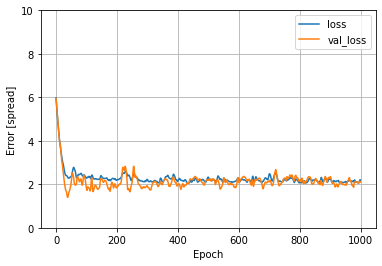

In [ ]:
# linreg model based on all parameters, nolags
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(train_features, train_labels,
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

def plot_loss(history, ceiling=10):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, ceiling])
  plt.xlabel('Epoch')
  plt.ylabel('Error [spread]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
tf.keras.utils.plot_model(
    dnn_model, to_file='dnn_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 17,550
Trainable params: 17,537
Non-trainable params: 13
_________________________________________________________________


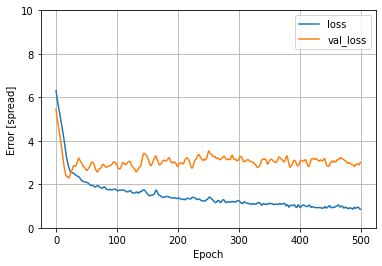

In [ ]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

plot_loss(history)

In [ ]:
# now add lags and repeat the above
lag = 12

dataset_with_lags = pd.DataFrame()

for i in range(0, lag):
  dataset_with_lags = pd.concat([dataset_with_lags, dataset.shift(i).add_prefix(f'{i}_lagged_')], axis=1)

dataset_with_lags = dataset_with_lags[lag:] # shift the NaNs away

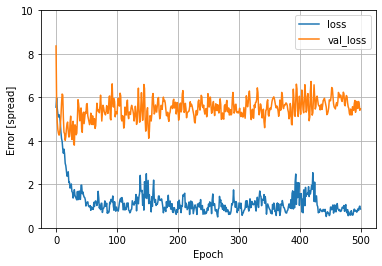

In [ ]:
train_dataset_with_lags = dataset_with_lags.sample(frac=0.8, random_state=42)

train_features_with_lags = train_dataset_with_lags.copy()
train_features_with_lags.pop('0_lagged_DA price')
train_features_with_lags.pop('0_lagged_Imb up price')
train_features_with_lags.pop('0_lagged_Imb down price')
train_labels_with_lags = train_features_with_lags.pop('0_lagged_spread')

test_dataset_with_lags = dataset_with_lags.drop(train_dataset_with_lags.index)
test_features_with_lags = test_dataset_with_lags.copy()
test_features_with_lags.pop('0_lagged_DA price')
test_features_with_lags.pop('0_lagged_Imb up price')
test_features_with_lags.pop('0_lagged_Imb down price')
test_labels_with_lags = test_features_with_lags.pop('0_lagged_spread')


normalizer_with_lags = preprocessing.Normalization(input_shape=[dataset_with_lags.shape[1]-4,])
normalizer_with_lags.adapt(np.array(train_features_with_lags))

linear_model_with_lags = tf.keras.Sequential([
    normalizer_with_lags,
    layers.Dense(units=1)
])

linear_model_with_lags.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history_with_lags = linear_model_with_lags.fit(train_features_with_lags, train_labels_with_lags,
    epochs=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 40% of the training data
    validation_data = (test_features_with_lags, test_labels_with_lags))

plot_loss(history_with_lags, ceiling=10)

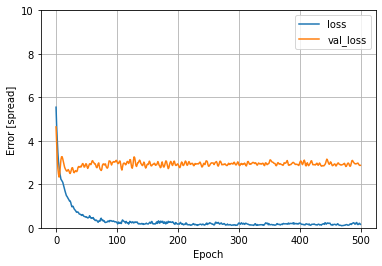

In [ ]:
# Overfits?
dnn_model_with_lags = build_and_compile_model(normalizer_with_lags)
history_with_lags = dnn_model_with_lags.fit(
    train_features_with_lags, train_labels_with_lags,
    validation_data=(test_features_with_lags, test_labels_with_lags),
    verbose=0, epochs=500)

plot_loss(history_with_lags, ceiling=10)

No handles with labels found to put in legend.


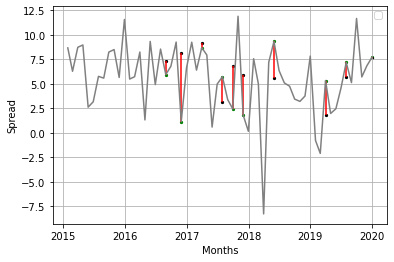

In [ ]:
plt.plot(dataset.index, dataset['spread'], color='grey')
plt.scatter(test_labels_with_lags.index, test_labels_with_lags, color='green', s=5)

res = dnn_model_with_lags.predict(test_features_with_lags)

plt.scatter(test_labels_with_lags.index, res, color='black', s=5)

for idx, idx_date in enumerate(test_labels_with_lags.index):
    plt.vlines(idx_date, res[idx], test_labels_with_lags[idx], colors='red')

plt.xlabel('Months')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)


In [ ]:
history_with_lags.history['val_loss'][-10:]

[2.945117712020874,
 2.9365487098693848,
 2.9506514072418213,
 2.945197343826294,
 2.970085620880127,
 2.9755096435546875,
 2.931668519973755,
 2.8860559463500977,
 2.8674426078796387,
 2.8723249435424805]

In [ ]:
tgt = test_features_with_lags[test_features_with_lags.index == '2019-12-31']
real_result = dataset[dataset.index == '2019-12-31']


predicted_result = dnn_model_with_lags.predict(tgt)


real_result

,All Prod,Prod Forecast,Cons Forecast,Wind Prod,Wind Forecast,DA price,Imb up price,Imb down price,Gas Price,spread
Settlement Date,,,,,,,,,,
2019-12-31,2161.922307,25655.685484,24066.870968,4236.879986,5973.783643,34.806774,27.064231,27.064231,32.640323,7.742543
